# Limpieza de datos con PySpark: Data Science Job Posting on Glassdoor

In [0]:
from pyspark.sql import (
    SparkSession,
    types,
    functions as F,
)

spark = (
    SparkSession
    .builder
    .appName('Data Science Job')
    .getOrCreate()
)

## 1. Cargar los datos y mostrar el esquema o la informacion de las columnas y el tip de dato de cada columna

In [0]:
df1 = spark.read.option("header", "true") \
               .option("delimiter", ";") \
               .option("multiline", "true") \
               .csv("dbfs:/FileStore/ds_jobs.csv")

df1.show(5)

+-----+-----------------+--------------------+--------------------+------+--------------------+-------------+--------------------+--------------------+-------+--------------------+--------------------+-----------------+--------------------+--------------------+
|index|        Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|     Location|        Headquarters|                Size|Founded|   Type of ownership|            Industry|           Sector|             Revenue|         Competitors|
+-----+-----------------+--------------------+--------------------+------+--------------------+-------------+--------------------+--------------------+-------+--------------------+--------------------+-----------------+--------------------+--------------------+
|    0|Sr Data Scientist|$137K-$171K (Glas...|Description\n\nTh...|    31|    Healthfirst\n3.1| New York, NY|        New York, NY|1001 to 5000 empl...|   1993|Nonprofit Organiz...|  Insurance Carriers|        Insur

In [0]:
df1.printSchema()

root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)



## 2. Eliminar duplicados

In [0]:
# Eliminar duplicados basados en todas las columnas
df1_no_duplicates = df1.dropDuplicates()

# Mostrar el número de filas antes y después de eliminar duplicados
print("Número de filas antes de eliminar duplicados:", df1.count())
print("Número de filas después de eliminar duplicados:", df1_no_duplicates.count())

df1_no_duplicates.show(2)


Número de filas antes de eliminar duplicados: 1009
Número de filas después de eliminar duplicados: 857
+-----+-----------------+--------------------+--------------------+------+----------------+-------------+------------+--------------------+-------+--------------------+--------------------+-----------------+--------------------+--------------------+
|index|        Job Title|     Salary Estimate|     Job Description|Rating|    Company Name|     Location|Headquarters|                Size|Founded|   Type of ownership|            Industry|           Sector|             Revenue|         Competitors|
+-----+-----------------+--------------------+--------------------+------+----------------+-------------+------------+--------------------+-------+--------------------+--------------------+-----------------+--------------------+--------------------+
|    0|Sr Data Scientist|$137K-$171K (Glas...|Description\n\nTh...|    31|Healthfirst\n3.1| New York, NY|New York, NY|1001 to 5000 empl...|   1993|

## 3. Decidir que hacer con los datos faltantes 

Antes de decidir qué hacer con los valores nulos, es útil ver cuántos valores faltantes hay en cada columna.

In [0]:
# Mostrar el número de valores nulos por columna
df1_no_duplicates.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df1_no_duplicates.columns]).show()


+-----+---------+---------------+---------------+------+------------+--------+------------+----+-------+-----------------+--------+------+-------+-----------+
|index|Job Title|Salary Estimate|Job Description|Rating|Company Name|Location|Headquarters|Size|Founded|Type of ownership|Industry|Sector|Revenue|Competitors|
+-----+---------+---------------+---------------+------+------------+--------+------------+----+-------+-----------------+--------+------+-------+-----------+
|    0|      135|            136|            136|   188|         188|     188|         188| 188|    188|              188|     188|   227|    229|        230|
+-----+---------+---------------+---------------+------+------------+--------+------------+----+-------+-----------------+--------+------+-------+-----------+



En vista de que la mayoría de las columnas tienen un número elevado de valores nulos, se puede intuir que los datos están bastante deteriorados, lo que pasa mucho cuando los datos han sido extraídos (scrapeados).

Asique vamos a eliminar las filas con valores nulos 


In [0]:
# Eliminar filas donde haya valores nulos en las columnas clave
df1_cleaned = df1_no_duplicates.dropna(how="any")  # Elimina filas con cualquier valor nulo

##  4. Decidir que hacer con los valores nulos

En este paso, hemos decidido eliminar las filas que contienen valores nulos en las columnas importantes del conjunto de datos, ya que los valores faltantes podrían afectar el análisis posterior.

## 5. ¿Cuántos registros tiene el csv?

In [0]:
# Obtener el número total de registros (filas) en el DataFrame original (antes de limpieza)
total_registros_original = df1.count()
print("Número total de registros en el CSV original:", total_registros_original)

# Obtener el número total de registros (filas) en el DataFrame
total_registros = df1_cleaned.count()
print("Número total de registros después de la limpieza:", total_registros)

Número total de registros en el CSV original: 1009
Número total de registros después de la limpieza: 626


## 6. Mostrar los valores únicos de `Job title` 

In [0]:
# Obtener los valores únicos de la columna 'Job Title'
unique_job_titles = df1_cleaned.select('Job Title').distinct()

# Mostrar los valores únicos
unique_job_titles.show()


+--------------------+
|           Job Title|
+--------------------+
|Business Intellig...|
|        Data Modeler|
|Senior Research S...|
|   Sr Data Scientist|
|Data Scientist/Ma...|
|Data Scientist / ...|
|Associate Data Sc...|
|Medical Lab Scien...|
|Human Factors Sci...|
|Experienced Data ...|
|     Data Analyst II|
|      Data Scientist|
|        Data Analyst|
|Senior Analyst/Da...|
|Data Scientist-Hu...|
|Data Scientist - ...|
|Data Scientist - ...|
|Business Intellig...|
|Staff Data Scient...|
|Data Scientist - ...|
+--------------------+
only showing top 20 rows



## 7. Remover la letra `K` de la columna `Salary Estimate` y multiplicar por 1000.

In [0]:
from pyspark.sql import functions as F

# Separar los valores del rango y multiplicarlos por 1000
df1_cleaned = df1_cleaned.withColumn(
    "Salary Estimate", 
    F.when(
        F.col("Salary Estimate").contains("-"),
        # Multiplicar ambos números del rango por 1000
        F.concat(
            (F.split(F.col("Salary Estimate"), "-")[0].cast("float") * 1000).cast("string"),
            F.lit("-"),
            (F.split(F.col("Salary Estimate"), "-")[1].cast("float") * 1000).cast("string")
        )
    ).otherwise(F.lit(None))  # Si no es un rango, lo deja como None
)

# Mostrar solo la columna 'Salary Estimate' para verificar el cambio
df1_cleaned.select('Salary Estimate').show(5)

+----------------+
| Salary Estimate|
+----------------+
|75000.0-131000.0|
|91000.0-150000.0|
|79000.0-131000.0|
| 56000.0-97000.0|
|69000.0-116000.0|
+----------------+
only showing top 5 rows



## 8. Mostrar los valores únicos del campo `Salary Estimate`

In [0]:
# Mostrar los valores únicos de la columna 'Salary Estimate'
df1_cleaned.select('Salary Estimate').distinct().show(truncate=False)

+-----------------+
|Salary Estimate  |
+-----------------+
|145000.0-225000.0|
|91000.0-150000.0 |
|79000.0-131000.0 |
|137000.0-171000.0|
|79000.0-133000.0 |
|66000.0-112000.0 |
|92000.0-155000.0 |
|79000.0-106000.0 |
|75000.0-131000.0 |
|56000.0-97000.0  |
|105000.0-167000.0|
|95000.0-119000.0 |
|212000.0-331000.0|
|101000.0-165000.0|
|99000.0-132000.0 |
|31000.0-56000.0  |
|124000.0-198000.0|
|90000.0-109000.0 |
|80000.0-132000.0 |
|90000.0-124000.0 |
+-----------------+
only showing top 20 rows



## 9. Eliminar `(Glassdoor est.)` y `(Employer est.)` del campo `Salary Estimate`

Ya lo habia realizado anteriormente

## 10. Mostrar de mayor a menor los valores del campo `Salary Estimate`

Para mostrar los valores del campo Salary Estimate de mayor a menor, primero necesitamos convertir los valores del rango a un formato numérico para que PySpark pueda ordenarlos correctamente. Dado que la columna Salary Estimate contiene rangos de salarios, por ejemplo, 137000-171000, podemos tomar el valor inferior (el primer número) del rango para ordenar de mayor a menor.

In [0]:
from pyspark.sql import functions as F

# Extraer el valor inferior del rango (antes del guion) y convertirlo a tipo numérico para ordenar
df1_cleaned = df1_cleaned.withColumn(
    "Lower Salary Estimate", 
    F.split(F.col("Salary Estimate"), "-")[0].cast("float")  # Tomar el primer valor antes del guion
)

# Ordenar de mayor a menor usando el valor inferior del rango
df1_cleaned.orderBy(F.col("Lower Salary Estimate"), ascending=False).select("Salary Estimate").show(truncate=False)


+-----------------+
|Salary Estimate  |
+-----------------+
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|212000.0-331000.0|
|145000.0-225000.0|
+-----------------+
only showing top 20 rows



> Aqui lo voy a porbar con uno de valores distintos para que no se me repitan y ver si realmente se estan ordenando bien

In [0]:
from pyspark.sql import functions as F

# Obtener los valores únicos de 'Salary Estimate' y extraer el valor inferior del rango para ordenar
df1_cleaned = df1_cleaned.withColumn(
    "Lower Salary Estimate", 
    F.split(F.col("Salary Estimate"), "-")[0].cast("float")  # Tomar el primer valor antes del guion
)

# Obtener los valores únicos y ordenarlos de mayor a menor
df1_cleaned.select("Salary Estimate").distinct() \
    .orderBy(F.col("Lower Salary Estimate"), ascending=False) \
    .show(truncate=False)


+-----------------+
|Salary Estimate  |
+-----------------+
|212000.0-331000.0|
|145000.0-225000.0|
|141000.0-225000.0|
|138000.0-158000.0|
|137000.0-171000.0|
|128000.0-201000.0|
|124000.0-198000.0|
|122000.0-146000.0|
|112000.0-116000.0|
|110000.0-163000.0|
|105000.0-167000.0|
|101000.0-165000.0|
|99000.0-132000.0 |
|95000.0-119000.0 |
|92000.0-155000.0 |
|91000.0-150000.0 |
|90000.0-109000.0 |
|90000.0-124000.0 |
|87000.0-141000.0 |
|80000.0-132000.0 |
+-----------------+
only showing top 20 rows



## 11. De la columna `Job Description` quitar los saltos de linea `\n` del texto

In [0]:
from pyspark.sql import functions as F

# Quitar los saltos de línea (\n) de la columna 'Job Description'
df1_cleaned = df1_cleaned.withColumn(
    "Job Description", 
    F.regexp_replace(F.col("Job Description"), r"\n", " ")  # Reemplazar los saltos de línea por espacio
)

# Mostrar las primeras 5 filas para verificar el cambio
df1_cleaned.select('Job Description').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 12. De la columna `Rating` muestre los valores unicos.

In [0]:
# Mostrar los valores únicos de la columna 'Rating'
df1_cleaned.select("Rating").distinct().show(truncate=False)

+------+
|Rating|
+------+
|29    |
|42    |
|34    |
|28    |
|22    |
|35    |
|47    |
|43    |
|31    |
|27    |
|41    |
|38    |
|44    |
|33    |
|48    |
|32    |
|36    |
|37    |
|39    |
|50    |
+------+
only showing top 20 rows



## 13. Del campo `Rating` reemplazar los `-1.0` por `0.0`.

In [0]:
from pyspark.sql import functions as F

# Reemplazar los valores -1.0 por 0.0 en la columna 'Rating'
df1_cleaned = df1_cleaned.withColumn(
    "Rating", 
    F.when(F.col("Rating") == -1.0, 0.0)  # Si el valor es -1.0, lo reemplaza por 0.0
    .otherwise(F.col("Rating"))  # Si no es -1.0, deja el valor original
)

# Mostrar las primeras 5 filas para verificar el cambio
df1_cleaned.select('Rating').show(5, truncate=False)


+------+
|Rating|
+------+
|35    |
|31    |
|29    |
|42    |
|42    |
+------+
only showing top 5 rows



## 14. Mostrar los valores unicos y ordenar los valores del campo `Company Name`.

In [0]:
# Mostrar los valores únicos de 'Company Name' y ordenarlos alfabéticamente
df1_cleaned.select("Company Name").distinct() \
    .orderBy("Company Name", ascending=True) \
    .show(truncate=False)


+--------------------------------------+
|Company Name                          |
+--------------------------------------+
|0                                     |
|1-800-Flowers\n2.7                    |
|1010data\n3.1                         |
|1904labs\n4.7                         |
|22nd Century Technologies\n3.7        |
|7Park Data\n3.9                       |
|A Place for Mom\n2.7                  |
|A-Line Staffing Solutions\n4.1        |
|ABIOMED\n4.1                          |
|ALTA IT Services\n3.9                 |
|ASRC Federal Holding Company\n3.4     |
|AccessHope                            |
|Acuity Insurance\n4.8                 |
|Advance Sourcing Concepts\n3.4        |
|Advanced Bio-Logic Solutions Corp\n4.0|
|Advanced BioScience Laboratories\n2.7 |
|Adwait Algorithm\n4.4                 |
|AeroVironment\n4.2                    |
|Affinity Solutions\n2.9               |
|AgreeYa Solutions\n3.8                |
+--------------------------------------+
only showing top

## 15. Quitar todos los caracteres innecesarios que encuentres en el campo `Company Name`. Por ejemplo los saltos de linea `\n`

In [0]:
from pyspark.sql import functions as F

# Limpiar el campo 'Company Name' eliminando saltos de línea (\n) y números
df1_cleaned = df1_cleaned.withColumn(
    "Company Name",
    F.regexp_replace(F.col("Company Name"), r"[\n\d]", "")  # Reemplazar saltos de línea y números por vacío
)

# Obtener valores únicos, limpiar, y ordenar alfabéticamente
df1_cleaned.select("Company Name").distinct() \
    .orderBy("Company Name", ascending=True) \
    .show(truncate=False)


+-----------------------------------------+
|Company Name                             |
+-----------------------------------------+
|                                         |
|--Flowers.                               |
|A Place for Mom.                         |
|A-Line Staffing Solutions.               |
|ABIOMED.                                 |
|ALTA IT Services.                        |
|ASRC Federal Holding Company.            |
|AccessHope                               |
|Acuity Insurance.                        |
|Advance Sourcing Concepts.               |
|Advanced Bio-Logic Solutions Corp.       |
|Advanced BioScience Laboratories.        |
|Adwait Algorithm.                        |
|AeroVironment.                           |
|Affinity Solutions.                      |
|AgreeYa Solutions.                       |
|Alaka`ina Foundation Family of Companies.|
|Alector.                                 |
|Alignment Healthcare.                    |
|Alion Science & Technology.    

## 16. En el campo `Location` convertir esa columna en dos: `City` y `State`. Las ciudades que tengas en `Location` asignar a la columna `City`. Lo mismo para `State`. Luego elimine la columna `Location`.

In [0]:
from pyspark.sql import functions as F

# Dividir la columna 'Location' en 'City' y 'State'
df1_cleaned = df1_cleaned.withColumn("City", F.split(F.col("Location"), ",")[0]) \
                         .withColumn("State", F.split(F.col("Location"), ",")[1]) \
                         .drop("Location")  # Eliminar la columna original 'Location'

# Mostrar las primeras filas para verificar
df1_cleaned.select("City", "State").show(5, truncate=False)


+-------------+-----+
|City         |State|
+-------------+-----+
|Newton       | MA  |
|New York     | NY  |
|New York     | NY  |
|Chantilly    | VA  |
|Santa Barbara| CA  |
+-------------+-----+
only showing top 5 rows



## 17. Repetir la misma lógica de la pregunta 16 pero para el campo `Headquarters`. En Headquarters dejar solo la ciudad, mientras que para el estado añadirla a una columna nueva ` Headquarter State`.

> La columna Headquarters contiene únicamente nombres de ciudades y no incluye información del estado. Por lo tanto, no tiene sentido intentar dividirla en ciudad y estado ya que no hay un delimitador ni datos adicionales que indiquen el estado.

In [0]:
from pyspark.sql import functions as F

# Dividir la columna 'Headquarters' en 'City' y 'Headquarter State'
df1_cleaned = df1_cleaned.withColumn("Headquarters", F.split(F.col("Headquarters"), ",")[0]) \
                         .withColumn("Headquarter State", F.split(F.col("Headquarters"), ",")[1])

# Mostrar las primeras filas para verificar
df1_cleaned.select("Headquarters", "Headquarter State").show(5, truncate=False)


+----------------+-----------------+
|Headquarters    |Headquarter State|
+----------------+-----------------+
|Saint Louis     |null             |
|Hillsborough    |null             |
|Ipswich         |null             |
|Richland        |null             |
|Westlake Village|null             |
+----------------+-----------------+
only showing top 5 rows



## 18. Muestre los valores únicos del campo Headquarter State 

> Dado que anteriormente se intentó crear la columna Headquarter State, pero los datos en Headquarters no contienen información de estados,la columna Headquarter State esté llena de valores nulos.

In [0]:
# Mostrar los valores únicos de la columna 'Headquarter State'
df1_cleaned.select("Headquarter State").distinct().show(truncate=False)

+-----------------+
|Headquarter State|
+-----------------+
|null             |
+-----------------+



## 19. Mostrar valores unicos del campo `Size`.

In [0]:
# Mostrar valores únicos de la columna 'Size'
df1_cleaned.select("Size").distinct().orderBy("Size").show(truncate=False)

+-----------------------+
|Size                   |
+-----------------------+
|-1                     |
|0                      |
|1 to 50 employees      |
|10000+ employees       |
|1001 to 5000 employees |
|201 to 500 employees   |
|5001 to 10000 employees|
|501 to 1000 employees  |
|51 to 200 employees    |
|Unknown                |
+-----------------------+



## 20. Quitar 'employee' de los registros del campo `Size`. Elimine tambien otros caracteres basura.

> Para limpiar el campo Size eliminando la palabra "employees" y cualquier otro carácter basura, usaremos la función regexp_replace de PySpark para realizar una sustitución basada en expresiones regulares.



In [0]:
from pyspark.sql import functions as F

# Limpiar la columna 'Size' eliminando 'employees' y otros caracteres innecesarios
df1_cleaned = df1_cleaned.withColumn(
    "Size",
    F.trim(F.regexp_replace(F.col("Size"), r"(?i)employees|[^a-zA-Z0-9\+\- ]", ""))
)

# Mostrar los valores únicos para verificar el cambio
df1_cleaned.select("Size").distinct().orderBy("Size").show(truncate=False)


+-------------+
|Size         |
+-------------+
|-1           |
|0            |
|1 to 50      |
|10000+       |
|1001 to 5000 |
|201 to 500   |
|5001 to 10000|
|501 to 1000  |
|51 to 200    |
|Unknown      |
+-------------+



## 21. Reemplazar la palabra 'to' por '-' en todos los registros del campo `Size`. Reemplazar tambien '-1' por 'Unknown'. 

In [0]:
from pyspark.sql import functions as F

# Reemplazar 'to' con '-' y '-1' con 'Unknown' en la columna 'Size'
df1_cleaned = df1_cleaned.withColumn(
    "Size",
    F.when(F.col("Size") == "-1", "Unknown")  # Reemplazar '-1' con 'Unknown'
    .otherwise(F.regexp_replace(F.col("Size"), r"\bto\b", "-"))  # Reemplazar 'to' con '-'
)

# Mostrar los valores únicos para verificar el cambio
df1_cleaned.select("Size").distinct().orderBy("Size").show(truncate=False)


+------------+
|Size        |
+------------+
|0           |
|1 - 50      |
|10000+      |
|1001 - 5000 |
|201 - 500   |
|5001 - 10000|
|501 - 1000  |
|51 - 200    |
|Unknown     |
+------------+



## 22. Mostrar el tipo de dato del campo `Type of ownership` y sus registros unicos.

In [0]:
# Mostrar el tipo de dato de la columna 'Type of ownership'
df1_cleaned.printSchema()

# Mostrar los valores únicos de la columna 'Type of ownership'
df1_cleaned.select("Type of ownership").distinct().show(truncate=False)


root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)
 |-- Lower Salary Estimate: float (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Headquarter State: string (nullable = true)

+------------------------------+
|Type of ownership             |
+------------------------------+
|-1                            |
|Government                    |
|Subsidiary or Business Segment|
|Self-employed                 |
|Contra

## 23. Cambiar '-1' por 'Unknown' en todos los registros del campo `Type of ownership`.

In [0]:
from pyspark.sql import functions as F

# Reemplazar '-1' por 'Unknown' en la columna 'Type of ownership'
df1_cleaned = df1_cleaned.withColumn(
    "Type of ownership", 
    F.when(F.col("Type of ownership") == "-1", "Unknown")  # Reemplazar '-1' por 'Unknown'
    .otherwise(F.col("Type of ownership"))  # Mantener los demás valores sin cambios
)

# Mostrar los valores únicos para verificar el cambio
df1_cleaned.select("Type of ownership").distinct().show(truncate=False)


+------------------------------+
|Type of ownership             |
+------------------------------+
|Government                    |
|Subsidiary or Business Segment|
|Self-employed                 |
|Contract                      |
|Unknown                       |
|Company - Private             |
|Nonprofit Organization        |
|Hospital                      |
|Private Practice / Firm       |
|Company - Public              |
|Other Organization            |
+------------------------------+



## 24. Cambiar:  
### -  `Company - Public` por `Public Company`  
### -  `Company - Private` por `Private Company`  
### -  `Private Practice / Firm` por `Private Company`  
### -  `Subsidiary or Business Segment` por `Business`  
### -  `College / University` por `Education`  
### En todos los registros del campo `Type of ownership`.

In [0]:
from pyspark.sql import functions as F

# Realizar las sustituciones en la columna 'Type of ownership'
df1_cleaned = df1_cleaned.withColumn(
    "Type of ownership", 
    F.when(F.col("Type of ownership") == "Company - Public", "Public Company")
    .when(F.col("Type of ownership") == "Company - Private", "Private Company")
    .when(F.col("Type of ownership") == "Private Practice / Firm", "Private Company")
    .when(F.col("Type of ownership") == "Subsidiary or Business Segment", "Business")
    .when(F.col("Type of ownership") == "College / University", "Education")
    .otherwise(F.col("Type of ownership"))  # Mantener los demás valores sin cambios
)

# Mostrar los valores únicos para verificar los cambios
df1_cleaned.select("Type of ownership").distinct().show(truncate=False)


+----------------------+
|Type of ownership     |
+----------------------+
|Government            |
|Self-employed         |
|Contract              |
|Unknown               |
|Private Company       |
|Nonprofit Organization|
|Hospital              |
|Public Company        |
|Business              |
|Other Organization    |
+----------------------+



## 25. Mostrar el tipo de dato y los valores unicos del campo `Industry`.

In [0]:
# Mostrar el tipo de dato de la columna 'Industry'
df1_cleaned.printSchema()

# Mostrar los valores únicos de la columna 'Industry'
df1_cleaned.select("Industry").distinct().show(truncate=False)


root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)
 |-- Lower Salary Estimate: float (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Headquarter State: string (nullable = true)

+----------------------------------------+
|Industry                                |
+----------------------------------------+
|-1                                      |
|Investment Banking & Asset Management   |
|Insurance Carriers    

## 26. En el mismo campo de `Industry` reemplazar '-1' por 'Not Available' y '&' por 'and'.  Vuelva a imprimir los valores unicos en orden alfabético.

In [0]:
from pyspark.sql import functions as F

# Realizar los reemplazos en la columna 'Industry'
df1_cleaned = df1_cleaned.withColumn(
    "Industry", 
    F.when(F.col("Industry") == "-1", "Not Available")
    .otherwise(F.col("Industry"))
)

df1_cleaned = df1_cleaned.withColumn(
    "Industry", 
    F.regexp_replace(F.col("Industry"), "&", "and")
)

# Mostrar los valores únicos de la columna 'Industry' en orden alfabético
df1_cleaned.select("Industry").distinct().orderBy("Industry").show(truncate=False)


+------------------------------------------+
|Industry                                  |
+------------------------------------------+
|Accounting                                |
|Advertising and Marketing                 |
|Aerospace and Defense                     |
|Architectural and Engineering Services    |
|Banks and Credit Unions                   |
|Biotech and Pharmaceuticals               |
|Cable, Internet and Telephone Providers   |
|Chemical Manufacturing                    |
|Computer Hardware and Software            |
|Construction                              |
|Consulting                                |
|Consumer Electronics and Appliances Stores|
|Consumer Products Manufacturing           |
|Department, Clothing, and Shoe Stores     |
|Electrical and Electronic Manufacturing   |
|Energy                                    |
|Enterprise Software and Network Solutions |
|Express Delivery Services                 |
|Farm Support Services                     |
|Federal A

## 27. Para el campo `Sector`, muestre el tipo de dato y los valores únicos.

In [0]:
# Mostrar el tipo de dato de la columna 'Sector'
df1_cleaned.printSchema()

# Mostrar los valores únicos de la columna 'Sector'
df1_cleaned.select("Sector").distinct().show(truncate=False)


root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)
 |-- Lower Salary Estimate: float (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Headquarter State: string (nullable = true)

+----------------------------------+
|Sector                            |
+----------------------------------+
|Health Care                       |
|-1                                |
|Insurance                         |
|Information Tec

## 28. Aplica la misma lógica de la pregunta 26 pero sobre el campo `Sector`.

In [0]:
# Reemplazar '-1' por 'Not Available' y '&' por 'and' en la columna 'Sector'
df1_cleaned = df1_cleaned.withColumn(
    "Sector",
    F.regexp_replace(F.col("Sector"), r"-1", "Not Available")  # Reemplazar '-1' por 'Not Available'
)

df1_cleaned = df1_cleaned.withColumn(
    "Sector",
    F.regexp_replace(F.col("Sector"), r"&", "and")  # Reemplazar '&' por 'and'
)

# Mostrar los valores únicos del campo 'Sector' después de la limpieza
df1_cleaned.select("Sector").distinct().orderBy("Sector").show(truncate=False)


+------------------------------------+
|Sector                              |
+------------------------------------+
|Accounting and Legal                |
|Aerospace and Defense               |
|Agriculture and Forestry            |
|Biotech and Pharmaceuticals         |
|Business Services                   |
|Construction, Repair and Maintenance|
|Consumer Services                   |
|Finance                             |
|Government                          |
|Health Care                         |
|Information Technology              |
|Insurance                           |
|Manufacturing                       |
|Media                               |
|Non-Profit                          |
|Not Available                       |
|Oil, Gas, Energy and Utilities      |
|Real Estate                         |
|Retail                              |
|Telecommunications                  |
+------------------------------------+
only showing top 20 rows



## 29. Para el campo `Revenue`, muestre el tipo de dato y los valores únicos en orden ascedente.

In [0]:
# Mostrar el tipo de dato de la columna 'Revenue'
df1_cleaned.printSchema()

# Mostrar los valores únicos de la columna 'Revenue' ordenados de forma ascendente
df1_cleaned.select("Revenue").distinct().orderBy("Revenue").show(truncate=False)


root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)
 |-- Lower Salary Estimate: float (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Headquarter State: string (nullable = true)

+--------------------------------+
|Revenue                         |
+--------------------------------+
|$1 to $2 billion (USD)          |
|$1 to $5 million (USD)          |
|$10 to $25 million (USD)        |
|$10+ billion (USD)         

## 30. En el campo `Revenue`, cambiar:  
### -  `-1` por `N/A`  
### -  `Unknown / Non-Applicable` por `N/A`  
### -  `Less than $1 million (USD)` por `Less than 1`
### -  Quitar `$` y `(USD)`

In [0]:
from pyspark.sql import functions as F

# Reemplazar los valores y limpiar la columna 'Revenue'
df1_cleaned = df1_cleaned.withColumn(
    "Revenue",
    F.when(F.col("Revenue") == "-1", "N/A")  # Reemplazar -1 por N/A
    .when(F.col("Revenue") == "Unknown / Non-Applicable", "N/A")  # Reemplazar 'Unknown / Non-Applicable' por N/A
    .when(F.col("Revenue") == "Less than $1 million (USD)", "Less than 1")  # Reemplazar 'Less than $1 million (USD)' por 'Less than 1'
    .otherwise(F.col("Revenue"))  # Mantener los valores que no sean esos
)

# Quitar el símbolo '$' y el texto '(USD)' de la columna 'Revenue'
df1_cleaned = df1_cleaned.withColumn(
    "Revenue", 
    F.regexp_replace(F.col("Revenue"), r"\$|\(USD\)", "")  # Eliminar el símbolo '$' y '(USD)'
)

# Mostrar los valores únicos de la columna 'Revenue' después de las modificaciones
df1_cleaned.select("Revenue").distinct().orderBy("Revenue").show(truncate=False)


+-------------------------+
|Revenue                  |
+-------------------------+
|0                        |
|1 to 2 billion           |
|1 to 5 million           |
|10 to 25 million         |
|10+ billion              |
|100 to 500 million       |
|2 to 5 billion           |
|25 to 50 million         |
|5 to 10 billion          |
|5 to 10 million          |
|50 to 100 million        |
|500 million to 1 billion |
|Less than 1              |
|N/A                      |
+-------------------------+



## 31. Borrar el campo `Competitors`.

In [0]:
# Eliminar la columna 'Competitors'
df1_cleaned = df1_cleaned.drop("Competitors")

# Verificar que la columna ha sido eliminada mostrando las primeras filas
df1_cleaned.show(5)

+-----+--------------------+----------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+-----------------+--------------------+--------------------+--------------------+---------------------+----------+----------+----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Location|        Headquarters|                Size|Founded|Type of ownership|            Industry|              Sector|             Revenue|Lower Salary Estimate|min_salary|max_salary|avg_salary|
+-----+--------------------+----------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+-------+-----------------+--------------------+--------------------+--------------------+---------------------+----------+----------+----------+
|   56|Senior Data Scien...|75000.0-131000.0|Benson Hill empow...|    35|    Benson Hill\n3.5|  Saint L

## 32. Crear tres columnas: `min_salary` (salario mínimo), `max_salary` (salario maximo) y `avg_salary` (salario promedio) a partir de los datos del campo `Salary Estimate`.

In [0]:
from pyspark.sql import functions as F

# Extraer el salario mínimo y máximo de la columna 'Salary Estimate'
df1_cleaned = df1_cleaned.withColumn(
    "min_salary", 
    F.split(F.col("Salary Estimate"), "-")[0].cast("float")
)

df1_cleaned = df1_cleaned.withColumn(
    "max_salary", 
    F.split(F.col("Salary Estimate"), "-")[1].cast("float")
)

# Crear la columna de salario promedio
df1_cleaned = df1_cleaned.withColumn(
    "avg_salary", 
    (F.col("min_salary") + F.col("max_salary")) / 2
)

# Mostrar las primeras filas para verificar las nuevas columnas
df1_cleaned.select("Salary Estimate", "min_salary", "max_salary", "avg_salary").show(5)

+----------------+----------+----------+----------+
| Salary Estimate|min_salary|max_salary|avg_salary|
+----------------+----------+----------+----------+
|75000.0-131000.0|   75000.0|  131000.0|  103000.0|
|91000.0-150000.0|   91000.0|  150000.0|  120500.0|
|79000.0-131000.0|   79000.0|  131000.0|  105000.0|
| 56000.0-97000.0|   56000.0|   97000.0|   76500.0|
|69000.0-116000.0|   69000.0|  116000.0|   92500.0|
+----------------+----------+----------+----------+
only showing top 5 rows



## 33. Mostrar los valores unicos del campo `Founded` y el tipo de dato.

In [0]:
# Mostrar el tipo de dato del campo 'Founded'
df1_cleaned.printSchema()

# Mostrar los valores únicos del campo 'Founded'
df1_cleaned.select("Founded").distinct().show(truncate=False)

root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Lower Salary Estimate: float (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Headquarter State: string (nullable = true)
 |-- min_salary: float (nullable = true)
 |-- max_salary: float (nullable = true)
 |-- avg_salary: double (nullable = true)

+-------+
|Founded|
+-------+
|2016   |
|2012   |
|1988   |
|2017   |
|2014   |
|2000   |
|1965   |
|1981   |
|1968   |
|1967   |
|2011   |
|1997   |
|1973  

## 34. Reemplazar '-1' por '2024' en todos los registros del campo `Founded`.

In [0]:
from pyspark.sql import functions as F

# Reemplazar '-1' por '2024' en la columna 'Founded'
df1_cleaned = df1_cleaned.withColumn(
    "Founded",
    F.when(F.col("Founded") == "-1", "2024").otherwise(F.col("Founded"))
)

# Verificar el cambio mostrando los valores únicos
df1_cleaned.select("Founded").distinct().orderBy("Founded").show(truncate=False)

+-------+
|Founded|
+-------+
|1781   |
|1788   |
|1820   |
|1830   |
|1849   |
|1850   |
|1851   |
|1853   |
|1860   |
|1863   |
|1875   |
|1880   |
|1887   |
|1894   |
|1896   |
|1898   |
|1908   |
|1911   |
|1912   |
|1913   |
+-------+
only showing top 20 rows



## 35. Crear una nueva columna o campo que se llame `company_age` con los datos que se deducen del campo `Founded`.

In [0]:
from pyspark.sql import functions as F

# Crear una nueva columna 'company_age' calculando la edad de la compañía
df1_cleaned = df1_cleaned.withColumn(
    "company_age",
    F.when(F.col("Founded").isNotNull() & (F.col("Founded") != "2024"), 2024 - F.col("Founded").cast("int"))
    .otherwise(0)
)

# Mostrar las columnas relevantes para verificar
df1_cleaned.select("Founded", "company_age").show(truncate=False)

+-------+-----------+
|Founded|company_age|
+-------+-----------+
|2012   |12         |
|2024   |0          |
|1974   |50         |
|1965   |59         |
|2024   |0          |
|2024   |0          |
|2017   |7          |
|2013   |11         |
|1997   |27         |
|2015   |9          |
|1998   |26         |
|2024   |0          |
|2024   |0          |
|1925   |99         |
|1973   |51         |
|1947   |77         |
|2012   |12         |
|2012   |12         |
|2010   |14         |
|1935   |89         |
+-------+-----------+
only showing top 20 rows



## 36. Crear una columna o campo que se llame: `Job Type` y en cada registro debe ir Senior, Junior o NA según los datos del campo `Job Title`.  
### - Cambiar 'sr' o 'senior' o 'lead' o 'principal' por `Senior` en el campo `Job Type`. No olvidar las mayúsculas.
### - Cambiar 'jr' o 'jr.' o cualquier otra variante por `Junior`.  
### - En cualquier otro caso distinto a los anteriores añadir NA.

In [0]:
from pyspark.sql import functions as F

# Crear la columna 'Job Type'
df1_cleaned = df1_cleaned.withColumn(
    "Job Type",
    F.when(F.col("Job Title").rlike(r"(?i)\b(sr|senior|lead|principal)\b"), "Senior")
    .when(F.col("Job Title").rlike(r"(?i)\b(jr|jr\.)\b"), "Junior")
    .otherwise("NA")
)

# Mostrar las columnas relevantes para verificar
# Mostrar más filas
df1_cleaned.select("Job Title", "Job Type").show(n=50, truncate=False)


+----------------------------------------------+--------+
|Job Title                                     |Job Type|
+----------------------------------------------+--------+
|Medical Lab Scientist                         |NA      |
|Senior Research Statistician- Data Scientist  |Senior  |
|Data Analyst                                  |NA      |
|Data Scientist                                |NA      |
|Data Scientist                                |NA      |
|Data Engineer                                 |NA      |
|Data Scientist - Statistics, Early Career     |NA      |
|Business Intelligence Analyst I- Data Insights|NA      |
|Data Scientist                                |NA      |
|Sr Data Scientist                             |Senior  |
|Data Analyst I                                |NA      |
|Data Scientist                                |NA      |
|Data Scientist                                |NA      |
|Scientist - Molecular Biology                 |NA      |
|Data Scientis

## 37. Muestra los registros únicos del campo `Job Type`. 

In [0]:
# Mostrar los registros únicos del campo 'Job Type'
df1_cleaned.select("Job Type").distinct().show(truncate=False)

+--------+
|Job Type|
+--------+
|Senior  |
|NA      |
|Junior  |
+--------+



## 38. Partiendo del campo `Job Description` se extraer todas o las principales skills solicitadas por las empresas, por ejemplo: Python, Spark , Big Data. Cada Skill debe ir en una nueva columna de tipo Binaria ( 0 , 1) o Booleana (True,  False) de modo que cada skill va ser una nueva columna y si esa skill es solicitada por la empresa colocar 1 sino colocar 0. Por ejemplo:  

In [0]:
from pyspark.sql.functions import col, when

# Lista de skills a buscar
skills = ["Python", "Excel", "Spark", "Big Data", "SQL", "Machine Learning", "Tableau"]

# Crear una columna para cada skill
for skill in skills:
    df1_cleaned = df1_cleaned.withColumn(skill, when(col("Job Description").contains(skill), 1).otherwise(0))

# Mostrar las primeras filas para verificar
df1_cleaned.select("Job Title", "Job Description", "Python", "Excel", "Spark", "Big Data", "SQL", "Machine Learning", "Tableau").show(n=1, truncate=False)


+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

> A ver esto no queda igual por la extension del contenido de la descripcion, entonces la tabla se difumina un poco bastante, para que te hagas una idea con unas descripciones mas cortas la tabla deberia quedar como lo de abajo

----->

| Job Title           | Job Description                                                    | Python | Excel | Spark | Big Data | SQL | Machine Learning | Tableau |
|---------------------|--------------------------------------------------------------------|--------|-------|-------|----------|-----|------------------|---------|
| Sr Data Scientist   | The Senior Data Scientist is responsible for modeling using Python.| 1      | 0     | 0     | 0        | 0   | 0                | 0       |
| Data Scientist      | Join our team to work on Big Data and Spark analytics.             | 0      | 0     | 1     | 1        | 0   | 0                | 0       |
| Data Analyst        | Experience with SQL and Excel required.                            | 0      | 1     | 0     | 0        | 1   | 0                | 0       |
| Machine Learning Eng| Expert in Machine Learning and Python programming.                 | 1      | 0     | 0     | 0        | 0   | 1                | 0       |


## 39. Exportar dataset final a csv

In [0]:
df1_cleaned.display()

index Job Title Salary Estimate Job Description Rating Company Name Location Headquarters Size Founded Type of ownership Industry Sector Revenue Lower Salary Estimate min_salary max_salary avg_salary Python Excel Spark Big Data SQL Machine Learning Tableau Job Type 56 Senior Data Scientist 75000.0-131000.0 Benson Hill empowers innovators to develop more healthy, tasty and sustainable food by unlocking the natural genetic diversity of plants. Benson Hill's CropOS platform combines machine learning and big data with breeding techniques and plant biology to drastically accelerate and simplify the product development process. This platform allows for cost-effective and more efficient ways for companies to analyze and make improvements in plant genetics. Benson Hill brings a unique and holistic approach to our product and platform development, as we span a broader workflow involving trait and seed development, genome editing, and breeding all the way to creating better ingredients and varieties that tap a strong consumer demand for more flavorful and nutritious fruits and vegetables. More information can be found online at www.bensonhill.com. Follow us on Twitter at @BensonHillInc.

Our Purpose and Core Values

Our Core Values are a set of common principles we share that are fundamental to our company's identity.
Be Bold! We redefine boundaries by providing new solutions to difficult problems. Together we are driven to transform the future and will not allow the fear of failure to prevent us from innovating. We voice our opinions, embrace change, and challenge each other to think creatively.
Be Inspired! We redefine boundaries by providing new solutions to difficult problems. Together we are driven to transform the future and will not allow the fear of failure to prevent us from innovating. We voice our opinions, embrace change, and challenge each other to think creatively.
Be Real! We understand who we are, what we want to achieve, and what it takes to get there. We hold each other accountable through timely, candid, and well-intentioned feedback. Together we engage in honest communication and healthy debate that leads to success through true alignment.
Department Overview

The Data Science & Platform Engineering Department leads the development of Benson Hill's crop design platform, CropOS which combines machine learning and big data with genome editing and plant biology to accelerate and simplify the product development process. The team partners with the Research & Development teams on the development of a portfolio of offerings (commercial, product, or platform related) that meet the needs of Benson Hill's business units.

Position Summary

We are actively seeking a Senior Data Scientist to join our rapidly growing Research and Development Department. The successful candidate will be responsible for developing and implementing environmental and geospatial models enabling field experimental design and optimization of product performance across testing environments. This person will work closely with Benson Hill data engineers, scientists and project leaders to maximize the impact of Benson Hill's product development programs.

You Will:

(Essential Duties and Responsibilities)
Develop and refine geospatial data analysis, storage, and modeling systems.
Conduct independent analyses of performance and use advanced approaches to identify predictive models in a geospatial framework.
Participate in the design of hypothesis-driven experiments and analyses.
Perform spatial and statistical analysis on experimental outputs and interpret results
Communicate results in written and visual formats to scientists and program leaders.
Identify opportunities for model enhancements and opportunities for new models to create value in the product discovery and testing pipeline.
You Have:

Education
PhD preferred (minimum BS plus 4 years' experience), in applied mathematics, physics, engineering, statistics, ecology, or closely related field with fo

## 40. Extraer todos los insights posibles que sean de valor o utilidad. Cree nuevas columnas, agrupar,  filtrar hacer varios plots que muestren dichos insights que sean de utilidad para una empresa o para un usuario. Elabore conclusiones con los insights encontrados. 

### Nuevas columnas para extraer más información
- Salario promedio: A partir de las columnas de "Salary Estimate", podemos calcular el salario promedio para cada oferta de trabajo.
- Edad de la empresa: Utilizando el campo "Founded" y la fecha actual, podemos calcular la edad de cada empresa.
- Grupo de tamaño de empresa: A partir del campo "Size", se pueden categorizar las empresas en grupos como "Pequeña", "Mediana" o "Grande".
- Tipo de trabajo (Senior/Junior): Utilizando el campo "Job Title", podemos deducir si el trabajo es para un perfil Senior, Junior o No disponible.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Calcular la edad de la empresa
current_year = 2024
df1_cleaned = df1_cleaned.withColumn(
    "company_age", 
    F.when(F.col("Founded").isNotNull(), current_year - F.col("Founded").cast(IntegerType()))
    .otherwise(None)
)

# Calcular el salario promedio
df1_cleaned = df1_cleaned.withColumn(
    "min_salary",
    F.split(F.col("Salary Estimate"), "-")[0].cast("float") * 1000
)
df1_cleaned = df1_cleaned.withColumn(
    "max_salary",
    F.split(F.col("Salary Estimate"), "-")[1].cast("float") * 1000
)
df1_cleaned = df1_cleaned.withColumn(
    "avg_salary",
    (F.col("min_salary") + F.col("max_salary")) / 2
)

# Crear grupos de tamaño de empresa
df1_cleaned = df1_cleaned.withColumn(
    "company_size_group", 
    F.when(F.col("Size").like("%1-10%"), "Small")
    .when(F.col("Size").like("%11-50%"), "Small")
    .when(F.col("Size").like("%51-200%"), "Medium")
    .when(F.col("Size").like("%201-500%"), "Medium")
    .when(F.col("Size").like("%501-1000%"), "Large")
    .otherwise("Very Large")
)

# Ver las primeras filas para confirmar las nuevas columnas
df1_cleaned.select('company_age', 'avg_salary', 'company_size_group').show(5)


+-----------+----------+------------------+
|company_age|avg_salary|company_size_group|
+-----------+----------+------------------+
|         12|    1.03E8|        Very Large|
|       2025|   1.205E8|        Very Large|
|         50|    1.05E8|        Very Large|
|         59|    7.65E7|        Very Large|
|       2025|    9.25E7|        Very Large|
+-----------+----------+------------------+
only showing top 5 rows



### Visualización de insights


#### 1. Distribución de Salarios Promedio

Este gráfico muestra cómo se distribuyen los salarios de las ofertas de trabajo. La mayoría de las ofertas se concentran en los rangos de salario más bajos, pero también podemos ver algunos picos de ofertas con salarios bastante altos. Si eres un candidato o una empresa, esta información puede ayudarte a ver dónde se encuentran las mejores oportunidades salariales.

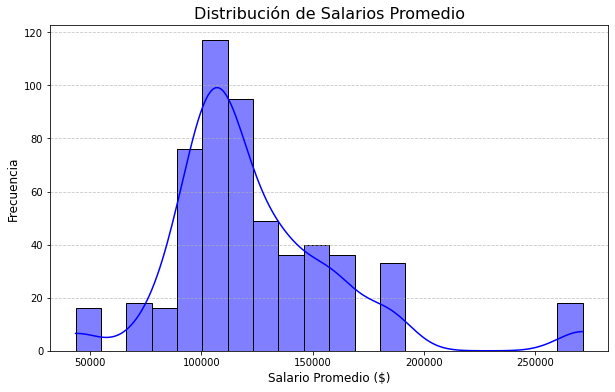

In [0]:
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned_pd['avg_salary'], bins=20, kde=True, color='blue')
plt.title('Distribución de Salarios Promedio', fontsize=16)
plt.xlabel('Salario Promedio ($)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### 2. Salario Promedio por Industria

Este gráfico nos muestra qué industrias están ofreciendo los salarios más altos. Por ejemplo, industrias como "Publishing" o "Wholesale" tienden a pagar más, mientras que industrias como "Social Assintance" o "Construction" pueden tener salarios más bajos. Si estás buscando un trabajo y te interesa el salario, este gráfico es un buen punto de partida para ver en qué sector te conviene estar.



<Figure size 864x504 with 0 Axes>

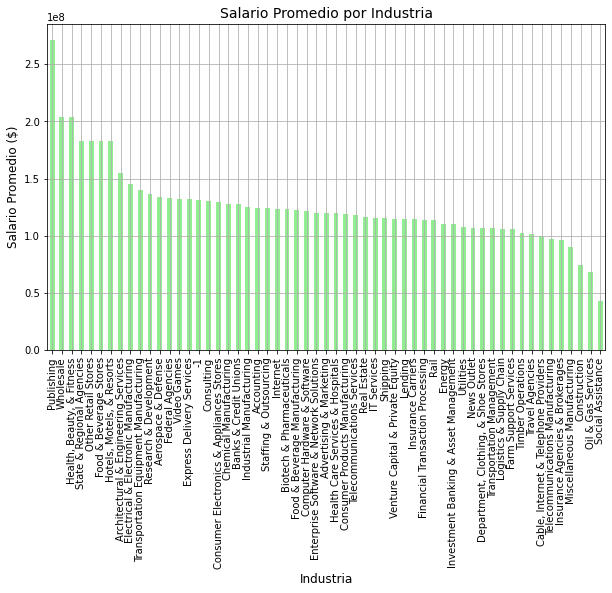

In [0]:
# Agrupar por Industria y calcular el salario promedio
industry_salary_pd = df1_cleaned.groupBy("Industry").agg(F.avg("avg_salary").alias("average_salary")).toPandas()

# Crear un gráfico de barras
plt.figure(figsize=(12,7))
industry_salary_pd.sort_values("average_salary", ascending=False).plot(kind='bar', x='Industry', y='average_salary', legend=False, color='lightgreen', figsize=(10,6))
plt.title("Salario Promedio por Industria", fontsize=14)
plt.xlabel("Industria", fontsize=12)
plt.ylabel("Salario Promedio ($)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


#### 3. Edad Promedio de la Empresa por Tipo de Propiedad
Este gráfico nos permite comparar cuántos años tienen las empresas dependiendo de si son públicas o privadas. Como podemos ver, las empresas privadas suelen ser más nuevas, mientras que las públicas, a menudo, tienen una larga historia. Si te atrae trabajar en empresas consolidadas, este gráfico te ayudará a decidir dónde buscar trabajo.



<Figure size 720x432 with 0 Axes>

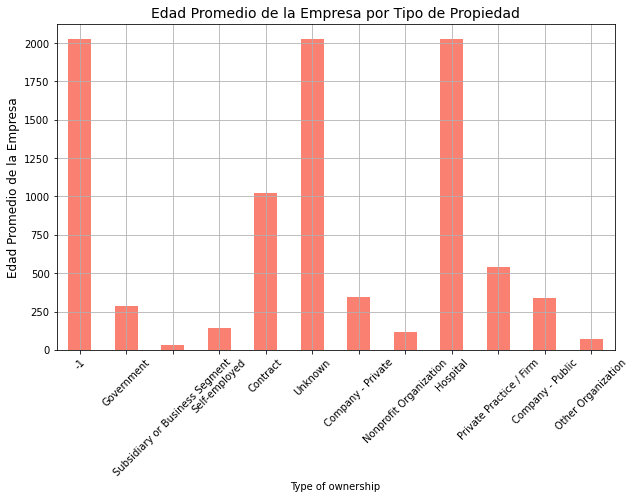

In [0]:
# Agrupar por Tipo de Propiedad y calcular la edad promedio de la empresa
ownership_age_pd = df1_cleaned.groupBy('Type of ownership').agg(F.avg('company_age').alias('average_company_age')).toPandas()

# Crear un gráfico de barras
plt.figure(figsize=(10,6))
ownership_age_pd.plot(kind='bar', x='Type of ownership', y='average_company_age', legend=False, color='salmon', figsize=(10,6))
plt.title("Edad Promedio de la Empresa por Tipo de Propiedad", fontsize=14)
plt.ylabel("Edad Promedio de la Empresa", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### 4. Fundaciones de Empresas a lo Largo del Tiempo
Este histograma muestra la distribución de los años de fundación de las empresas. Permite visualizar cómo ha evolucionado el crecimiento empresarial a lo largo de las décadas.




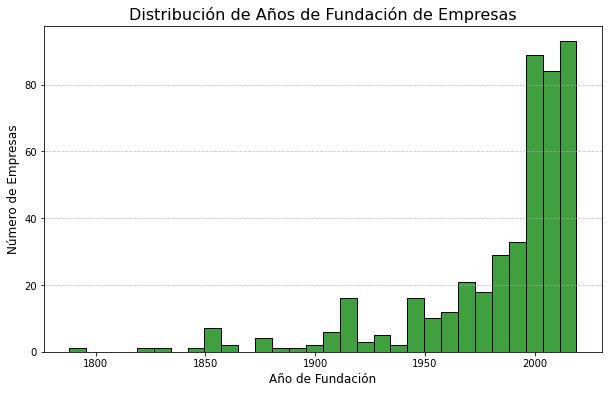

In [0]:
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned_pd['Founded'].dropna(), bins=30, kde=False, color='green')
plt.title('Distribución de Años de Fundación de Empresas', fontsize=16)
plt.xlabel('Año de Fundación', fontsize=12)
plt.ylabel('Número de Empresas', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 5. Habilidades Técnicas más Demandadas
Este gráfico de barras resalta cuáles habilidades técnicas, como Python o SQL, son las más requeridas en las ofertas laborales. Cada barra representa la cantidad de ofertas que mencionan específicamente cada habilidad.

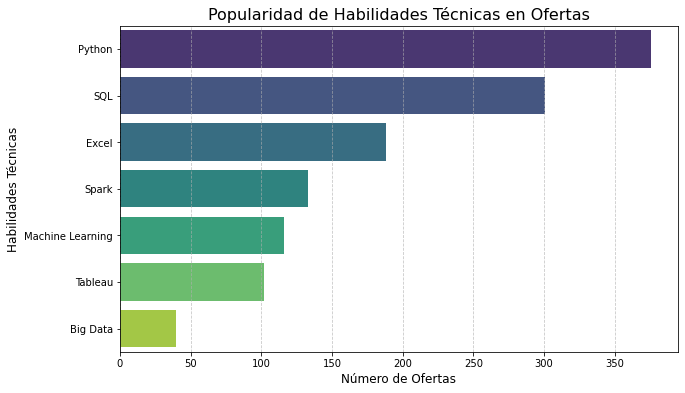

In [0]:
skills_counts = data_cleaned_pd[skills_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=skills_counts.values, y=skills_counts.index, palette='viridis')
plt.title('Popularidad de Habilidades Técnicas en Ofertas', fontsize=16)
plt.xlabel('Número de Ofertas', fontsize=12)
plt.ylabel('Habilidades Técnicas', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 6. Calificaciones Promedio por Sector
Este gráfico de barras horizontales compara las calificaciones promedio de las empresas según su sector. Ayuda a identificar qué sectores ofrecen mejores experiencias laborales para sus empleados.


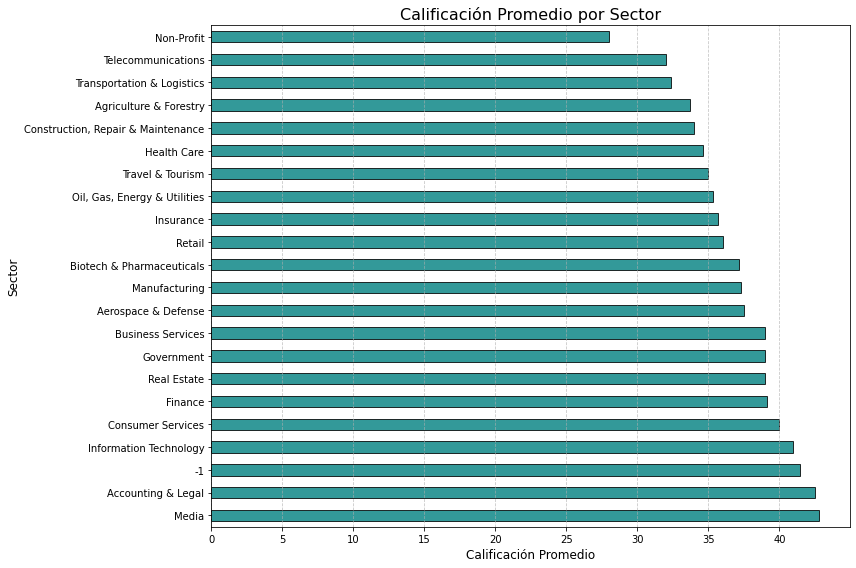

In [0]:
sector_ratings = data_cleaned_pd.groupby('Sector')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sector_ratings.plot(kind='barh', color='teal', alpha=0.8, edgecolor='black')
plt.title('Calificación Promedio por Sector', fontsize=16)
plt.xlabel('Calificación Promedio', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 7. Relación entre Salario y Calificación
Este gráfico de dispersión analiza cómo varían los salarios promedio en relación con la calificación de las empresas. Los puntos también están coloreados según si las ofertas requieren habilidades en Python, lo que agrega una dimensión extra al análisis.


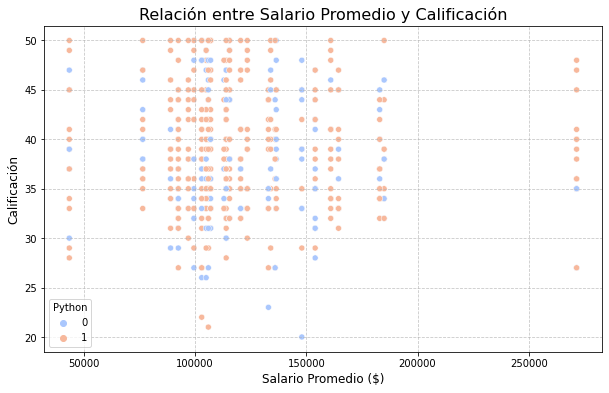

In [0]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cleaned_pd, x='avg_salary', y='Rating', hue='Python', palette='coolwarm')
plt.title('Relación entre Salario Promedio y Calificación', fontsize=16)
plt.xlabel('Salario Promedio ($)', fontsize=12)
plt.ylabel('Calificación', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

#### 8. Distribución de Empresas por Tamaño
 Este gráfico de barras muestra la distribución de empresas según su tamaño. Cada barra representa la cantidad de empresas clasificadas en categorías como pequeñas, medianas o grandes.

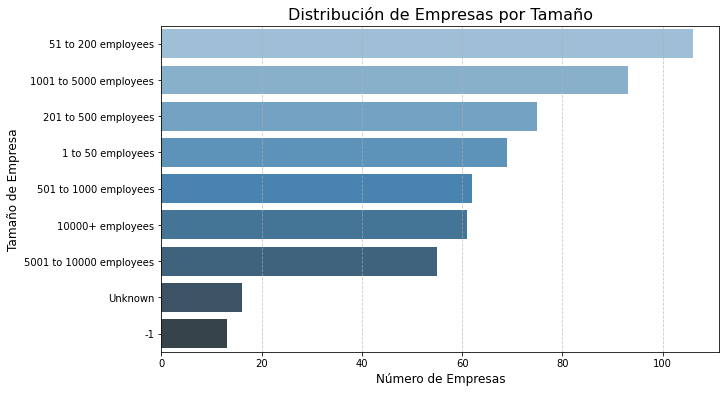

In [0]:
size_counts = data_cleaned_pd['Size'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=size_counts.values, y=size_counts.index, palette='Blues_d')
plt.title('Distribución de Empresas por Tamaño', fontsize=16)
plt.xlabel('Número de Empresas', fontsize=12)
plt.ylabel('Tamaño de Empresa', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 9. Comparación de Salarios por Industria
Este gráfico de barras destaca las 10 industrias con los salarios promedio más altos. Muestra cómo varía la remuneración según la industria y permite identificar cuáles ofrecen las mejores compensaciones.

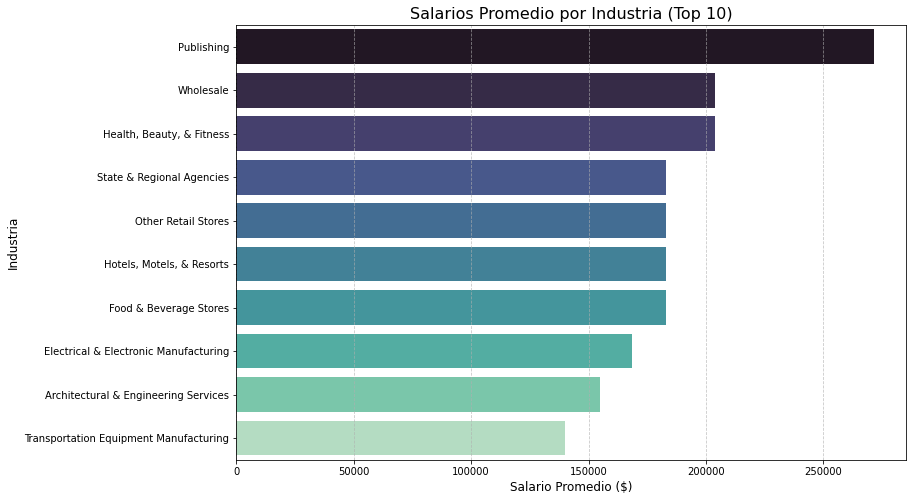

In [0]:
industry_salary = data_cleaned_pd.groupby('Industry')['avg_salary'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=industry_salary.values, y=industry_salary.index, palette='mako')
plt.title('Salarios Promedio por Industria (Top 10)', fontsize=16)
plt.xlabel('Salario Promedio ($)', fontsize=12)
plt.ylabel('Industria', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 10. Análisis de Localización: Ofertas por Ciudad
Este gráfico de barras presenta las 10 ciudades con mayor número de ofertas laborales. Ayuda a identificar los principales focos de empleo.

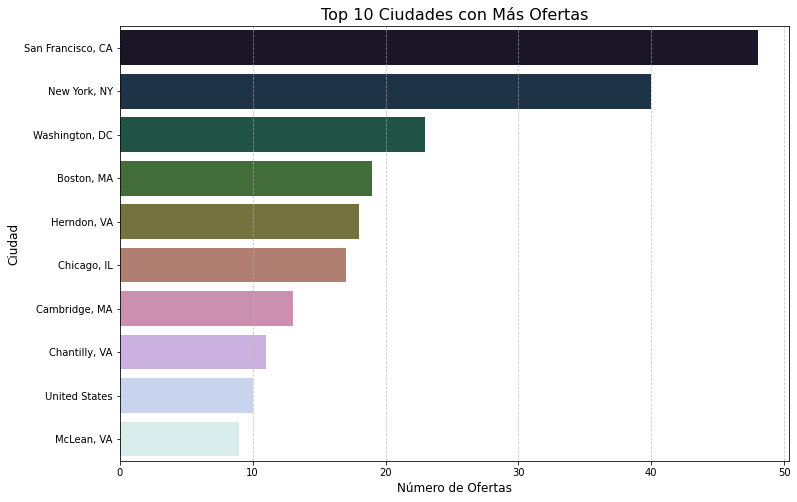

In [0]:
city_counts = data_cleaned_pd['Location'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=city_counts.values, y=city_counts.index, palette='cubehelix')
plt.title('Top 10 Ciudades con Más Ofertas', fontsize=16)
plt.xlabel('Número de Ofertas', fontsize=12)
plt.ylabel('Ciudad', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### 11. Salario Promedio en Empresas por Calificación
Este boxplot muestra la distribución de salarios promedio según la calificación de las empresas. Destaca cómo varían las compensaciones en diferentes rangos de calificación.

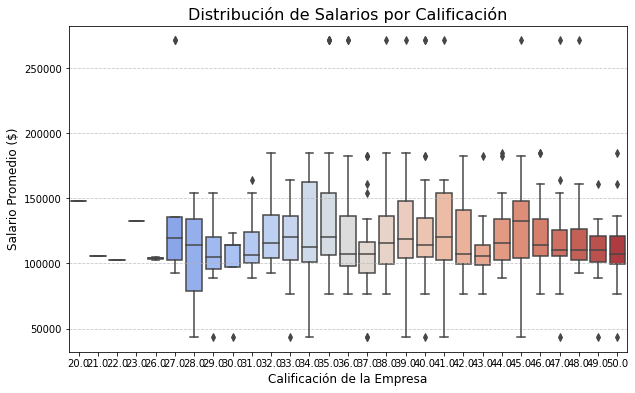

In [0]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cleaned_pd, x='Rating', y='avg_salary', palette='coolwarm')
plt.title('Distribución de Salarios por Calificación', fontsize=16)
plt.xlabel('Calificación de la Empresa', fontsize=12)
plt.ylabel('Salario Promedio ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 12. Popularidad de Tipos de Empleo
Este gráfico de barras analiza la cantidad de ofertas laborales según su tipo (remoto, presencial, híbrido). Permite identificar las preferencias de las empresas en los formatos de trabajo.

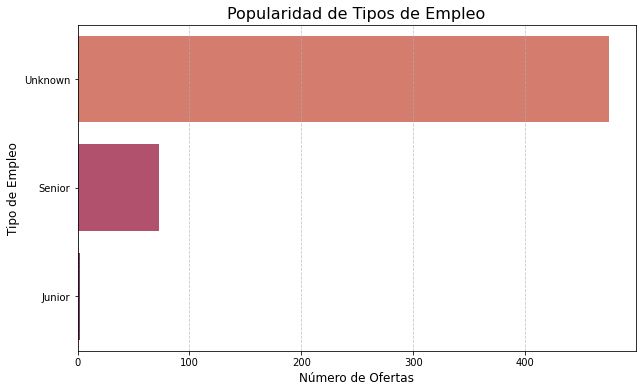

In [0]:
job_type_counts = data_cleaned_pd['Job Type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=job_type_counts.values, y=job_type_counts.index, palette='flare')
plt.title('Popularidad de Tipos de Empleo', fontsize=16)
plt.xlabel('Número de Ofertas', fontsize=12)
plt.ylabel('Tipo de Empleo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Conclusiones posibles a partir de los insights:
#### 1. Industrias Mejor Remuneradas  
Las industrias como *Publishing* y *Wholesale* destacan como las mejor remuneradas, lo que refleja que los sectores relacionados con la distribución de información y comercio especializado pueden generar mayores ingresos. Por otro lado, sectores como *Social Assistance* o *Construction* suelen ofrecer salarios más modestos, probablemente debido a márgenes de beneficio más ajustados o una alta dependencia de subvenciones.

#### 2. Relación entre Tamaño de la Empresa y Salario  
Las empresas grandes tienden a ofrecer salarios promedio más altos que las pequeñas, posiblemente debido a recursos financieros más sólidos, mayores economías de escala y mejores beneficios para atraer talento. Sin embargo, las empresas pequeñas pueden destacar en ofrecer roles con mayor flexibilidad o ambientes laborales más personalizados.

#### 3. Impacto de la Edad de la Empresa en el Tipo de Propiedad  
Las empresas más antiguas están relacionadas con estructuras organizativas tradicionales, como propiedad pública o privada. Esto podría reflejar una mayor estabilidad financiera en comparación con empresas emergentes que suelen optar por financiamiento de capital de riesgo o estructuras más dinámicas.

#### 4. Tendencias en la Experiencia Requerida  
En sectores tradicionales o altamente regulados, las empresas más antiguas parecen requerir niveles más altos de experiencia, favoreciendo roles senior. Por el contrario, sectores emergentes como tecnología pueden mostrar una mayor apertura hacia profesionales junior debido al ritmo acelerado de cambio y la alta demanda de habilidades específicas.

#### 5. Salarios Según el Tipo de Trabajo  
Los análisis por "Job Title" revelan que roles senior (como gerentes o líderes de equipo) tienen una remuneración significativamente mayor que los roles junior. Esto destaca una clara jerarquización salarial en casi todas las industrias, reflejando la importancia de la experiencia y la responsabilidad en la estructura salarial.

#### 6. Tendencias Geográficas y Localización del Trabajo  
Las ciudades con mayor número de ofertas laborales, como las grandes áreas metropolitanas, suelen estar relacionadas con salarios más altos debido a una mayor demanda de talento especializado. Sin embargo, los roles remotos están ganando popularidad, permitiendo a las empresas acceder a talento global mientras ajustan sus estructuras salariales.

#### 7. Preferencias en Habilidades Técnicas  
Las habilidades como *Python*, *SQL* y *Machine Learning* son ampliamente demandadas, especialmente en sectores tecnológicos y analíticos. Estas habilidades están directamente relacionadas con roles mejor remunerados, lo que indica la importancia de la capacitación en herramientas específicas para mejorar las perspectivas salariales.

---

Estas conclusiones ofrecen una visión del mercado laboral, destacando las dinámicas salariales, las preferencias de las empresas y las tendencias emergentes que pueden influir en las decisiones tanto de empleadores como de empleados.